In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [18]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from utils import load_data

In [21]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


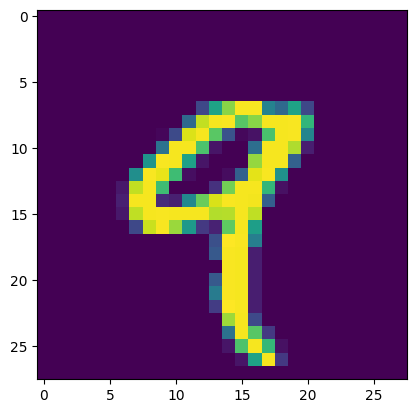

In [22]:
plt.imshow(train_input[4].view((28,28)))
plt.show()

In [23]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [24]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [44]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.tanh(x) ** 2

In [45]:
def loss (v,t):
    return torch.sum(torch.pow(t - v, 2))

def dloss(v,t):
    return 2 * (v - t)

In [46]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 3.5529,  1.1427, -0.1610, -2.0885, -3.8716, -4.2020],
        [ 1.1891,  2.0751,  4.8847,  1.2422, -1.4316, -4.5210],
        [ 5.5198, -1.9320, -1.5009, -2.7508,  0.8101,  1.0077]])

In [47]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [48]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [49]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50))
w2 = torch.randn((50, 10))
b2 = torch.randn((10))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [50]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.0514, grad_fn=<SumBackward0>))

In [51]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.05143737792969


In [52]:
b2.grad.shape

torch.Size([10])

In [53]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1) * dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2) * dh2
cmp('z2',dz2, z2)
dw2 = h1.t() @ dz2
cmp('w2',dw2, w2)
db2 = torch.sum(dz2, dim=0)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.t()
cmp('h1',dh1, h1)
dz1 = dh1 * dsigma(z1)
cmp('z1', dz1, z1)
dw1 = x1.t() @ dz1
cmp('w1', dw1, w1)
db1 = torch.sum(dz1, dim=0)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
w2              | exact: False | approximate: True  | maxdiff: 2.9802322387695312e-08
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: False | approximate: True  | maxdiff: 5.960464477539063e-08
z1              | exact: False | approximate: True  | maxdiff: 4.423782229423523e-09
w1              | exact: False | approximate: True  | maxdiff: 2.384185791015625e-07
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [54]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [55]:
l = loss(h2, y1)
l.item()

43.05143737792969

##### Now that we've checked our gradients are correct, we can implement the network

In [ ]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1
    h1 = sigma(z1)
    z2 = h1 @ w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [58]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2, y1) * dl
    dz2 = dsigma(z2) * dh2
    dw2 = h1.t() @ dz2
    db2 = torch.sum(dz2, dim=0)
    dh1 = dz2 @ w2.t()
    dz1 = dh1 * dsigma(h1)
    dw1 = x1.t() @ dz1
    db1 = torch.sum(dz1, dim=0)
    return dw1, db1, dw2, db2

In [ ]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1.squeeze()
        w2 += -lr * dw2 
        b2 += -lr * db2.squeeze()
    return w1, b1, w2, b2

In [60]:
def init():
    """ init a network """
    w1 = torch.randn((784, 50)) * 0.01
    b1 = torch.zeros((50))
    w2 = torch.randn((50, 10)) * 0.01
    b2 = torch.zeros((10))
    return w1, b1, w2, b2

In [61]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [62]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

        
    

In [63]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 656.06982421875
step = 100, loss = 209.91659545898438
step = 200, loss = 176.82791137695312
step = 300, loss = 141.88497924804688
step = 400, loss = 144.99105834960938
step = 500, loss = 183.1968536376953
step = 600, loss = 95.58345031738281
step = 700, loss = 102.70835876464844
step = 800, loss = 89.84367370605469
step = 900, loss = 93.30296325683594
step = 1000, loss = 78.17240905761719
step = 1100, loss = 73.38107299804688
step = 1200, loss = 89.69393920898438
step = 1300, loss = 66.58746337890625
step = 1400, loss = 91.35459899902344
step = 1500, loss = 73.11929321289062
step = 1600, loss = 64.92453002929688
step = 1700, loss = 45.919986724853516
step = 1800, loss = 52.77146911621094
step = 1900, loss = 45.5755729675293
step = 2000, loss = 35.193782806396484
step = 2100, loss = 34.29883575439453
step = 2200, loss = 38.88541793823242
step = 2300, loss = 39.70770263671875
step = 2400, loss = 47.380184173583984
step = 2500, loss = 37.25238800048828
step = 2600, loss =

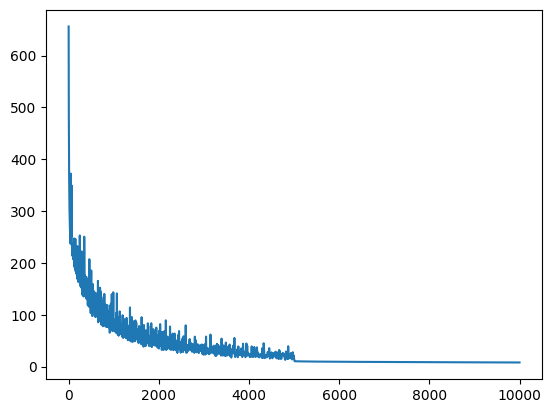

In [64]:
plt.plot(lossi)
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [65]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [66]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [67]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 661.5146484375
step = 100, loss = 185.95069885253906
step = 200, loss = 160.59521484375
step = 300, loss = 95.6285171508789
step = 400, loss = 98.55654907226562
step = 500, loss = 73.85990142822266
step = 600, loss = 50.29433822631836
step = 700, loss = 55.913883209228516
step = 800, loss = 39.07036590576172
step = 900, loss = 45.53143310546875
step = 1000, loss = 43.066375732421875
step = 1100, loss = 27.092853546142578
step = 1200, loss = 35.29233169555664
step = 1300, loss = 31.75717544555664
step = 1400, loss = 33.75291061401367
step = 1500, loss = 31.437030792236328
step = 1600, loss = 36.15453338623047
step = 1700, loss = 24.007265090942383
step = 1800, loss = 27.11014747619629
step = 1900, loss = 23.103496551513672
step = 2000, loss = 21.48311996459961
step = 2100, loss = 18.374614715576172
step = 2200, loss = 14.999570846557617
step = 2300, loss = 17.156673431396484
step = 2400, loss = 18.30756378173828
step = 2500, loss = 14.863430976867676
step = 2600, loss =

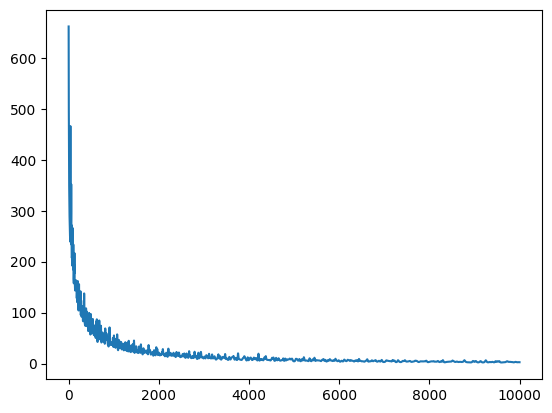

In [68]:
plt.plot(lossi)
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [69]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [83]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [87]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(n_in, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_out),
            nn.Tanh()
        ))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [88]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')




step =      0	loss=0.11791	accuracy (train, test): 0.10600	0.22200
step =   1000	loss=0.00033	accuracy (train, test): 1.00000	0.86500
step =   2000	loss=0.00042	accuracy (train, test): 1.00000	0.87100
step =   3000	loss=0.00001	accuracy (train, test): 1.00000	0.87600
step =   4000	loss=0.00002	accuracy (train, test): 1.00000	0.87300
step =   5000	loss=0.00017	accuracy (train, test): 1.00000	0.87900
step =   6000	loss=0.00001	accuracy (train, test): 1.00000	0.88000
step =   7000	loss=0.00007	accuracy (train, test): 1.00000	0.88000
step =   8000	loss=0.00003	accuracy (train, test): 1.00000	0.88000
step =   9000	loss=0.00005	accuracy (train, test): 1.00000	0.88100


##### Exercise: try to improve accuracy!

In [ ]:
# We normalize the data to have zero mean and unit variance, which is a common practice when training neural networks. 
X_tr = (X_tr - X_tr.mean()) / (X_tr.std() + 1e-8)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-8)

# Before normalization : 
#step =   9000	loss=0.00001	accuracy (train, test): 1.00000	0.87700

# After normalization : 
# step =   9000	loss=0.00005	accuracy (train, test): 1.00000	0.88100
